Mapping the geological profile from borehole data
----

Data - 10 Borehole data | each borhole is of 30m depth and consisting of data -
1. UCS (unaxial compressive strength)
2. RQD (rock quality designation)

Objective - Mapping the rock profile from given borehole data.

note: To derive the RMR (Rock Mass Rating) - the rating for UCS and RQD at each level is used (as per IS code) 
(RMR is added as a new column)

In [86]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [87]:
data = pd.read_csv('rmr.csv')
data.head()

,Unnamed: 0,Depth,easting,northing,rmr,UCS,RQD
0,0,8.25,276816.883,2114086.734,3.697130,8.52,0.0
1,1,11.25,276816.883,2114086.734,31.935841,29.61,39.0
2,2,14.25,276816.883,2114086.734,41.511956,32.95,54.0
3,3,17.25,276816.883,2114086.734,18.755503,14.70,23.0
4,4,20.25,276816.883,2114086.734,40.274700,1.68,66.0


Text(0,0.5,'Depth (m)')

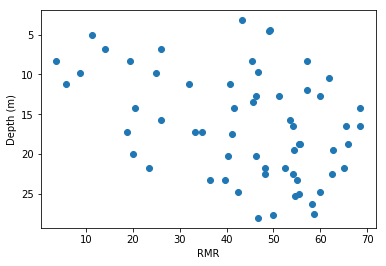

In [88]:
plt.scatter(data['rmr'],data['Depth'])
plt.gca().invert_yaxis()
plt.xlabel('RMR')
plt.ylabel('Depth (m)')

In [89]:
# Pearson R value - tells the association between two variables 
stats.pearsonr(data['rmr'],data['Depth'])[0]

0.3865313256910861

The Pearson correlation coefficient, r, can take a range of values from +1 to -1. A value of 0 indicates that there is no association between the two variables. A value greater than 0 indicates a positive association; that is, as the value of one variable increases, so does the value of the other variable.

Clearly the linear model is not a better model from the graph above. Hence we will use non-linear model to predict the RMR values

Random Forest to predict the soil/rock property
-----

In [90]:
tree_dataset = data[['Depth','easting','northing','rmr','UCS','RQD']]
tree_dataset.to_csv('rmr.csv')
tree_dataset.head()

# Normalizing the easting and northing for better modelling 
easting = min(tree_dataset['easting'])
northing = min(tree_dataset['northing'])
tree_dataset['X'] = tree_dataset['easting'] - easting
tree_dataset['Y'] = tree_dataset['northing'] - northing

In [91]:
tree_dataset.head()

,Depth,easting,northing,rmr,UCS,RQD,X,Y
0,8.25,276816.883,2114086.734,3.697130,8.52,0.0,8.104,19.71
1,11.25,276816.883,2114086.734,31.935841,29.61,39.0,8.104,19.71
2,14.25,276816.883,2114086.734,41.511956,32.95,54.0,8.104,19.71
3,17.25,276816.883,2114086.734,18.755503,14.70,23.0,8.104,19.71
4,20.25,276816.883,2114086.734,40.274700,1.68,66.0,8.104,19.71


In [92]:
# function to plot the borehole layout as per data
def plot_borhole_layout(size=(5,5),along=30):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    X,Y = tree_dataset['X'].unique(), tree_dataset['Y'].unique()
    for i,(x,y)  in enumerate(zip(X,Y)):
        ax.scatter(x,y)
        ax.text(x+0.3,y+0.3,'BH '+str(i+1),fontsize=11)
    ax.set_xlabel('easting')
    ax.set_ylabel('northing')
    ax.plot([along,along],[min(Y),max(Y)],linestyle='dashed',marker='x',markersize=14,color='black')
    return ax

Plotting the RMR values along a section

this model seems far better model than the linear one because it is classifying the results quite well based on the given features. however we can still improve the model using a different algorithm.

Random Forest model to predict soil/rock properties
---

In [93]:
# modelling
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators = 10)
X_tree = tree_dataset[['Depth','X','Y']].values


# function to return the index from the x_coordinates which depends on the resolution
def return_index(coordinate,xs):
    value = coordinate/max(tree_dataset['X'])
    if value >1:
        value=1
    index = int(value*(len(xs)-1))
    return index

Input for the function below [ **map_rock_profile()** ]- 
1. rock property - which is to be mapped. you can even use it for soil depending upon the borehole data.
2. coordinate - section on which we want to see the profile depending upon the areas of interest.
3. Resolution - The number of divisions in x and y axis in the elevation profile. Increasing the number of divisions will make the plot finer but will increase the computation time. I have used 25 divisions on each axis.

In [94]:
def map_rock_profile(rock_property, coordinate = 5 ,resolution=20):
    
    # change the dependent variable (rock property to be plotted along northing, easting & depth)
    Y_tree = tree_dataset[rock_property].values
    randomForest.fit(X_tree,Y_tree)
    
    # 1. PREPARING THE 2-D MATRIX FOR PLOTTING
    # ====================================
    # Northing
    y_cors = tree_dataset['Y'].values
    Y_cors = np.linspace(min(y_cors),max(y_cors),num=resolution)
    # depth
    Z_cors = np.linspace(0,30,num=resolution)
    # easting 
    x_cors = tree_dataset['X'].values
    X_cors = np.linspace(min(x_cors),max(x_cors),num=resolution)

    X_grid,Y_grid,Z_grid = np.meshgrid(X_cors,Y_cors,Z_cors) 

    prop_value = np.zeros((len(X_grid),len(Y_grid),len(Z_grid)))
    for x in range(resolution):
            for y in range(resolution):
                for z in range(resolution):
                    predict = np.array([Z_cors[z],X_cors[x],Y_cors[y]]).reshape(1,3)
                    prop_value[z,x,y] = randomForest.predict(predict)

    # 2. PLOTTING THE PROFILE WITH DESIRED PROPERTY
    # ======================================

    # plot the borehole layout with section marking in the plan
    ax1 = plot_borhole_layout(along=X_cors[return_index(coordinate,X_cors)])
    ax1.set_title('Borhole layout with section marking')

    # Plotting the elevation of the profile at that particular section
    fig = plt.figure(figsize=(15,5)) 
    plot = prop_value[:,return_index(coordinate,X_cors),:]  # prop_value[z,x,y]
    ax = fig.add_subplot(111)
    Y1_grid,Z1_grid = np.meshgrid(Y_cors,Z_cors)
    contour = ax.contourf(Y1_grid,Z1_grid,plot,cmap=plt.get_cmap('jet'),label=rock_property.upper())
    fig.colorbar(contour,ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel('Northing')
    ax.set_ylabel('Depth (m)')
    ax.set_title('Elevation profile showing: '+rock_property.upper()+' for X-X section in borehole layout above')
    ax.legend([rock_property])

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


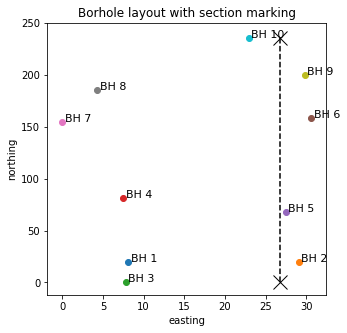

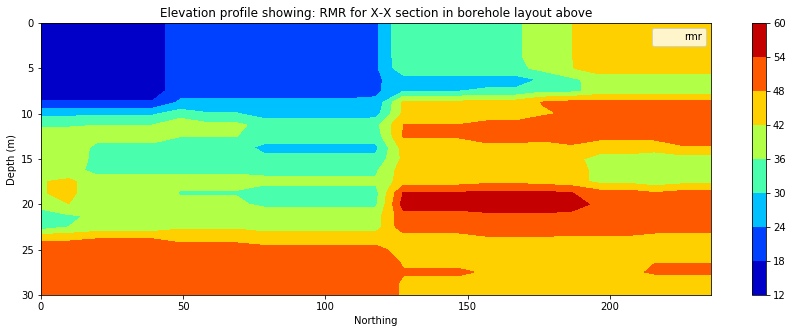

In [95]:
map_rock_profile(rock_property='rmr',coordinate=28,resolution=25)

- This plot shows location based rock grading (RMR), which can be very handy for design purpose like design of deep excavation works, NATM works etc.
- we can also use to plot other properties available in the table like for example UCS.

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


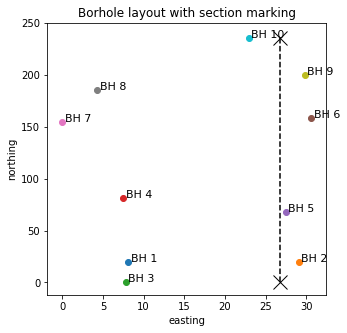

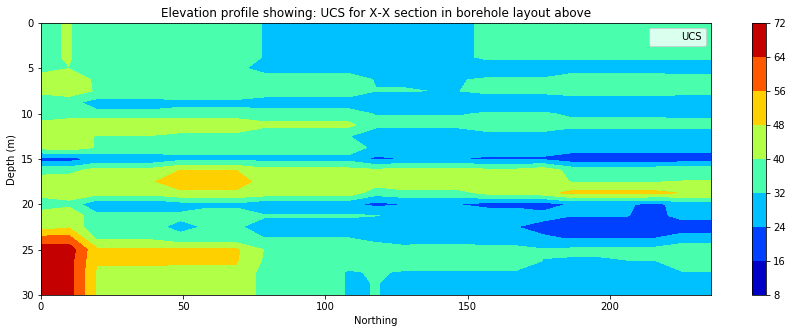

In [96]:
map_rock_profile(rock_property='UCS',coordinate=28,resolution=25)

- This plot shows the UCS at different depths at X-X section in the layout.
- There are many correlations for UCS to predict the bearing capacity, skin friction values for socket pile, bolts etc. This is plot can be further updated to predict these values using coorelation.